## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
from torch import tensor
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import seaborn as sns
sns.set_theme(style='darkgrid')


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


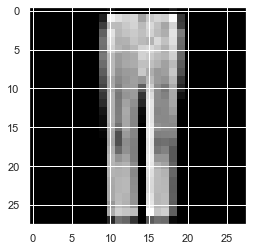

In [33]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    plt.imshow(img[0][0], cmap='gray')
    print(label.shape)
    print(label.size(0))
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
                nn.Conv2d(input_channels, 32, 5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, 5, padding=0),
                nn.ReLU(inplace=True),
                nn.Flatten(),
                nn.Linear(8*8*128, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_classes)
            ).cuda()
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [9]:
torchsummary.summary(TinyNeuralNetwork(), (1, 28, 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 12, 12]          18,496
              ReLU-5           [-1, 64, 12, 12]               0
            Conv2d-6            [-1, 128, 8, 8]         204,928
              ReLU-7            [-1, 128, 8, 8]               0
           Flatten-8                 [-1, 8192]               0
            Linear-9                  [-1, 512]       4,194,816
             ReLU-10                  [-1, 512]               0
           Linear-11                   [-1, 10]           5,130
Total params: 4,424,202
Trainable params: 4,424,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

Your experiments come here:

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() 
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            
            prediction = model.forward(x)    
            
            loss_value = loss(prediction, y)
            optimizer.zero_grad(set_to_none=True)
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(float(val_accuracy))
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if scheduler is not None:
            scheduler.step()
        print('-' * 75)
        
    return loss_history, train_history, val_history

        
def compute_accuracy(model, loader):

    model.eval() 
    total_samples = 0
    correct_samples = 0
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        prediction = model(x)
        total_samples += y.shape[0]
        correct_samples += torch.sum(torch.argmax(prediction, dim=1) == y)
    
    accuracy = correct_samples / total_samples
    return accuracy


def plot_results(loss, train_accuracy, val_accuracy):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 16))
    
    ax[0].plot(loss, lw=3, color=sns.color_palette()[0])

    ax[0].set_xlabel('epoch', fontsize=18)
    ax[0].set_ylabel('loss', fontsize=18)
    ax[0].set_title("Average loss on train", fontsize=20)
    
    ax[0].tick_params(axis='both', labelsize=16)
    
    ax[1].plot(train_accuracy, lw=3, color=sns.color_palette()[0],
              label='Train')
    ax[1].plot(val_accuracy, lw=3, color=sns.color_palette()[3],
              label='Validation')
    
    ax[1].set_title("Accuracy", fontsize=20)
    ax[1].set_xlabel('epoch', fontsize=18)
    ax[1].set_ylabel('accuracy', fontsize=18)
    ax[1].legend(shadow = True, fontsize=18, loc='upper left')
    ax[1].tick_params(axis='both', labelsize=16)
    
    plt.show()


model = TinyNeuralNetwork().to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.9),
                       lr=4e-3, weight_decay=0)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                milestones=[3, 10, 18], gamma=0.2)
num_epochs = 25

Epoch 1/25
Average loss: 0.484453, Train accuracy: 0.822517, Val accuracy: 0.870800
---------------------------------------------------------------------------
Epoch 2/25
Average loss: 0.288621, Train accuracy: 0.892700, Val accuracy: 0.892300
---------------------------------------------------------------------------
Epoch 3/25
Average loss: 0.248700, Train accuracy: 0.908367, Val accuracy: 0.900400
---------------------------------------------------------------------------
Epoch 4/25
Average loss: 0.169790, Train accuracy: 0.936800, Val accuracy: 0.917100
---------------------------------------------------------------------------
Epoch 5/25
Average loss: 0.143235, Train accuracy: 0.946667, Val accuracy: 0.918000
---------------------------------------------------------------------------
Epoch 6/25
Average loss: 0.124167, Train accuracy: 0.954067, Val accuracy: 0.918300
---------------------------------------------------------------------------
Epoch 7/25
Average loss: 0.108056, Train

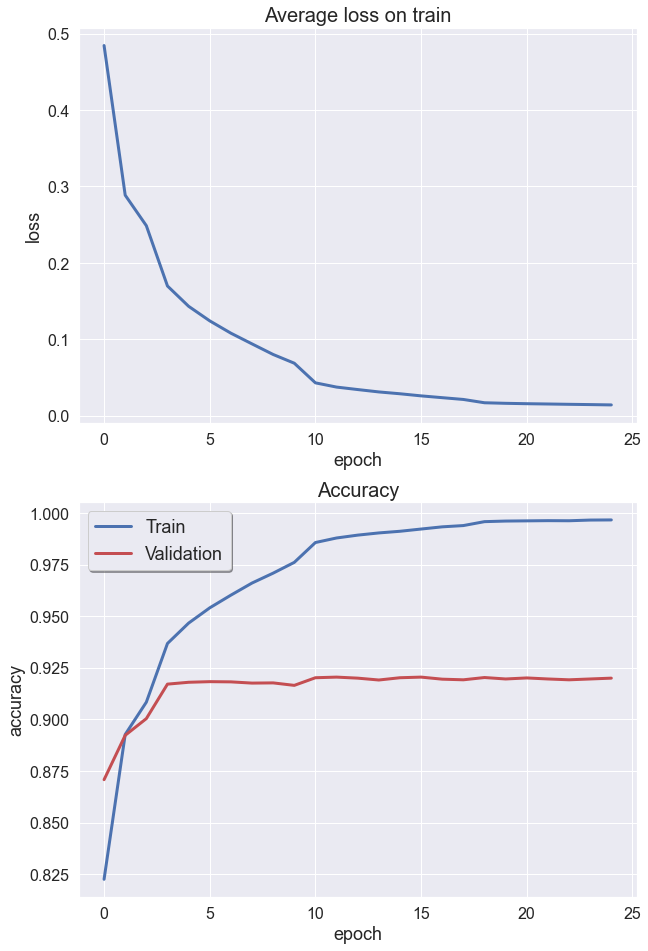

In [64]:
loss_history, train_history, val_history = train_model(model, train_loader, 
                                             test_loader, loss, optimizer, 
                                                 num_epochs, scheduler)

print("\n")
print(f'Test accuracy: {compute_accuracy(model, test_loader)}')

plot_results(loss_history, train_history, val_history)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

#### Network above already overfitted, so there's no need to repeat that.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [53]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
                nn.Conv2d(input_channels, 32, 5, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=0),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 128, 5, padding=0),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Flatten(),
                nn.Dropout(p=0.3),
                nn.Linear(8*8*128, 512),
                nn.BatchNorm1d(512),
                nn.Dropout(p=0.2),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_classes)
            ).cuda()
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [54]:
torchsummary.summary(FixedNeuralNetwork().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8            [-1, 128, 8, 8]         204,928
       BatchNorm2d-9            [-1, 128, 8, 8]             256
             ReLU-10            [-1, 128, 8, 8]               0
          Flatten-11                 [-1, 8192]               0
          Dropout-12                 [-1, 8192]               0
           Linear-13                  [-1, 512]       4,194,816
      BatchNorm1d-14                  [

In [59]:
train_transform_aug = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=0, translate=(0.072, 0.072))
                    ])

fmnist_dataset_train_aug = torchvision.datasets.FashionMNIST(root_path, 
                                                    train=True, 
                                                    transform=train_transform_aug,
                                                    target_transform=None,
                                                    download=download)

train_loader_aug = torch.utils.data.DataLoader(fmnist_dataset_train_aug, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

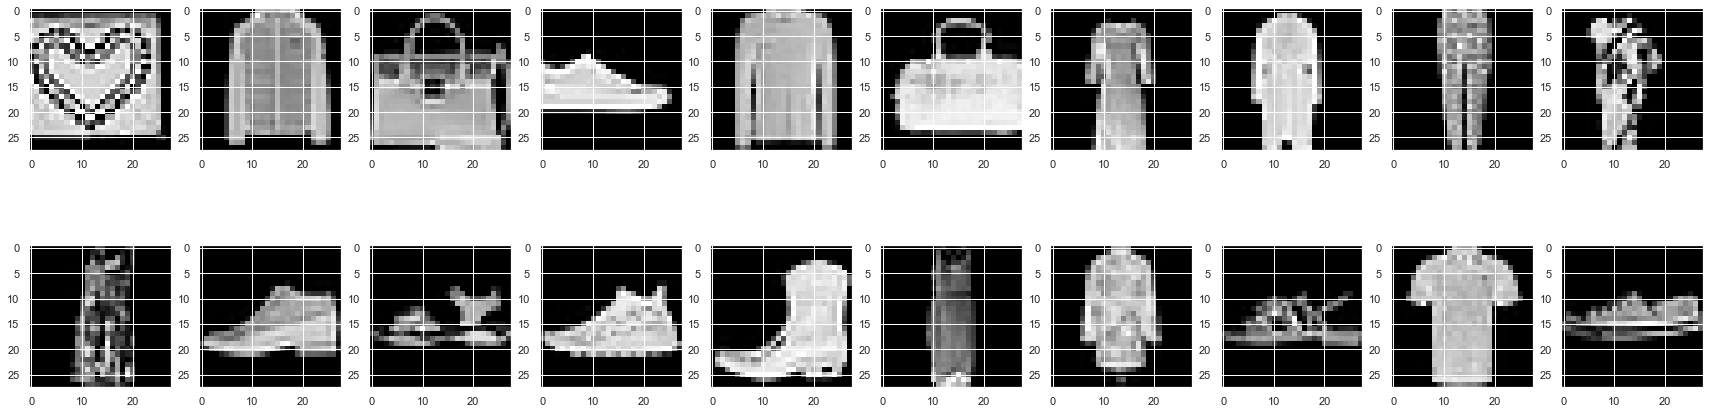

In [60]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize = (30, 8))

for img, label in train_loader_aug:
    for i in range(0, 100, 10):
        ax[0][i//10].imshow(img[i][0], cmap='gray')
    break

for img, label in train_loader:
    for i in range(0, 100, 10):
        ax[1][i//10].imshow(img[i][0], cmap='gray')
    break

In [64]:
import math
class CosineDecayWithWarmUpScheduler(object):
    def __init__(self, optimizer, step_per_epoch=1, init_warmup_lr=1e-6,
                 warm_up_steps=0, max_lr=1e-3, min_lr=5e-5,
                 num_step_down=10, num_step_up=0,
                 T_mul=1, max_lr_decay='Exp',
                 gamma=0.5, min_lr_decay='Exp', alpha=0.2):
        self.optimizer = optimizer
        self.step_per_epoch = step_per_epoch
        if warm_up_steps != 0:
            self.warm_up = True
        else:
            self.warm_up = False
        self.init_warmup_lr = init_warmup_lr
        self.warm_up_steps = warm_up_steps
        self.max_lr = max_lr
        if min_lr == 0:
            self.min_lr = 0.1 * max_lr
            self.alpha = 0.1
        else:
            self.min_lr = min_lr
        self.num_step_down = num_step_down
        if num_step_up == None:
            self.num_step_up = num_step_down
        else:
            self.num_step_up = num_step_up
        self.T_mul = T_mul
        if max_lr_decay == None:
            self.gamma = 1
        elif max_lr_decay == 'Half':
            self.gamma = 0.5
        elif max_lr_decay == 'Exp':
            self.gamma = gamma

        if min_lr_decay == None:
            self.alpha = 1
        elif min_lr_decay == 'Half':
            self.alpha = 0.5
        elif min_lr_decay == 'Exp':
            self.alpha = alpha

        self.num_T = 0
        self.iters = 0
        self.lr_list = []

    def update_cycle(self, lr):
        old_min_lr = self.min_lr
        if lr == self.max_lr or (self.num_step_up == 0 and lr == self.min_lr):
            if self.num_T == 0:
                self.warm_up = False
                self.min_lr /= self.alpha
            self.iters = 0
            self.num_T += 1
            self.min_lr *= self.alpha

        if lr == old_min_lr and self.max_lr * self.gamma >= self.min_lr:
            self.max_lr *= self.gamma

    def step(self):
        self.iters += 1
        if self.warm_up:
            lr = self.init_warmup_lr + (self.max_lr - self.init_warmup_lr) / self.warm_up_steps * self.iters
        else:
            T_cur = self.T_mul ** self.num_T
            if self.iters <= self.num_step_down * T_cur:
                lr = self.min_lr + (self.max_lr - self.min_lr) * (
                            1 + math.cos(math.pi * self.iters / (self.num_step_down * T_cur))) / 2
                if lr < self.min_lr:
                    lr = self.min_lr
            elif self.iters > self.num_step_down * T_cur:
                lr = self.min_lr + (self.max_lr - self.min_lr) / (self.num_step_up * T_cur) * (
                            self.iters - self.num_step_down * T_cur)
                if lr > self.max_lr:
                    lr = self.max_lr

        self.update_cycle(lr)

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            self.lr_list.append(lr)

In [68]:
try:
    del model_fixed
except: pass

model_fixed = FixedNeuralNetwork().to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

optimizer = optim.Adam(model_fixed.parameters(), betas=(0.9, 0.95),
                       lr=4e-3, weight_decay=1e-6)

scheduler = CosineDecayWithWarmUpScheduler(optimizer, max_lr=4e-3, min_lr=3e-5, 
                       num_step_down=18, num_step_up=0, gamma=0.4, alpha=0.1)


optimizer2 = optim.Adam(model_fixed.parameters(), betas=(0.9, 0.95),
                       lr=3e-6, weight_decay=1e-6)

scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, 
                                milestones=[7, 12], gamma=0.2)

num_epochs = 36
num_epochs2 = 16

Epoch 1/36
Average loss: 0.506611, Train accuracy: 0.810867, Val accuracy: 0.883200
---------------------------------------------------------------------------
Epoch 2/36
Average loss: 0.349159, Train accuracy: 0.872817, Val accuracy: 0.890300
---------------------------------------------------------------------------
Epoch 3/36
Average loss: 0.306541, Train accuracy: 0.888267, Val accuracy: 0.896100
---------------------------------------------------------------------------
Epoch 4/36
Average loss: 0.282410, Train accuracy: 0.895933, Val accuracy: 0.898700
---------------------------------------------------------------------------
Epoch 5/36
Average loss: 0.260479, Train accuracy: 0.906217, Val accuracy: 0.912800
---------------------------------------------------------------------------
Epoch 6/36
Average loss: 0.246587, Train accuracy: 0.910133, Val accuracy: 0.911500
---------------------------------------------------------------------------
Epoch 7/36
Average loss: 0.235212, Train

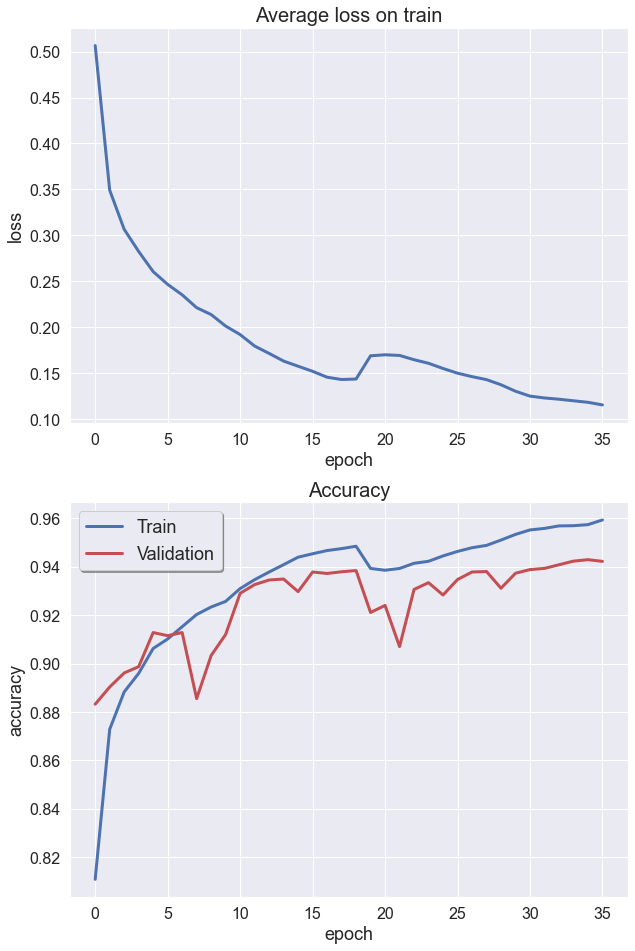

In [66]:
loss_history, train_history, val_history = train_model(model_fixed, train_loader_aug, 
                                            test_loader, loss, optimizer, 
                                                num_epochs, scheduler)

print("\n")
print(f'Test accuracy: {compute_accuracy(model_fixed, test_loader)}')

plot_results(loss_history, train_history, val_history)

We got decent result, but let's try to tune it a little:

Epoch 1/16
Average loss: 0.114356, Train accuracy: 0.958250, Val accuracy: 0.943400
---------------------------------------------------------------------------
Epoch 2/16


C:\Users\Nikita\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 0.113765, Train accuracy: 0.958767, Val accuracy: 0.943500
---------------------------------------------------------------------------
Epoch 3/16
Average loss: 0.114336, Train accuracy: 0.959600, Val accuracy: 0.943100
---------------------------------------------------------------------------
Epoch 4/16
Average loss: 0.114713, Train accuracy: 0.959033, Val accuracy: 0.942600
---------------------------------------------------------------------------
Epoch 5/16
Average loss: 0.116306, Train accuracy: 0.958083, Val accuracy: 0.942600
---------------------------------------------------------------------------
Epoch 6/16
Average loss: 0.115416, Train accuracy: 0.957400, Val accuracy: 0.942200
---------------------------------------------------------------------------
Epoch 7/16
Average loss: 0.114356, Train accuracy: 0.957900, Val accuracy: 0.943500
---------------------------------------------------------------------------
Epoch 8/16
Average loss: 0.115279, Train accuracy: 

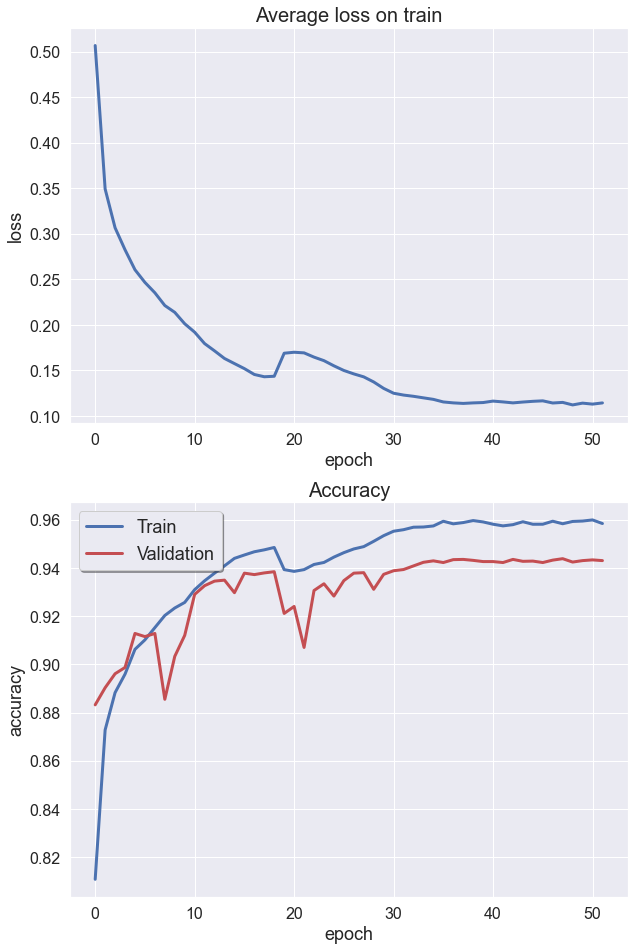

In [69]:
loss_history2, train_history2, val_history2 = train_model(model_fixed, train_loader_aug, 
                                            test_loader, loss, optimizer2, 
                                                num_epochs2, scheduler2) 

print("\n")
print(f'Test accuracy: {compute_accuracy(model_fixed, test_loader)}')

plot_results(loss_history+loss_history2, train_history+train_history2, 
             val_history+val_history2)

Got a little improvement, kind of within error variation though. Will stop here, because the task is not to get best result possible.

### Conclusions:
_Write down small report with your conclusions and your ideas._

According to testing, dropouts and data augmentation help a lot to cope with overfitting, although augmentations should be chosen carefully to avoid ruining whole learning. Good scheduler improves the result a little bit, making accuracy and loss plot look a little weird in return.